In [1]:
from functions import *
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
params = read_parameters()
subfolder = params['subfolder']
file_idx = params['file_idx']
drop_initial_final_off_rows = params['drop_initial_final_off_rows']
drop_off_rows = params['drop_off_rows']
plot_scatterplot_matrix = params['plot_scatterplot_matrix']
drop_outliers = params['drop_outliers']

subfolder: UF/
file_idx: 0
tmp_idx: 0
initial_feed_volume_L: 100
reset_columns_when_OFF: True
drop_initial_final_off_rows: True
drop_off_rows: True
drop_outliers: True
plot_scatterplot_matrix: False
use_default_arima_params: True
default_arima_params: [1, 1, 0]
include_arima_simulations_in_analysis: True


In [3]:
in_folder  = PATH_SENSORS_DATA_EXT_UF_V1
cur_file, file_path = get_input_file(in_folder=in_folder, in_file_idx=file_idx, log=True)

file list:
0 ../data/extended/UF/v1/2023-11-08 0 clean water.csv
1 ../data/extended/UF/v1/2023-11-09 0 clean water.csv
2 ../data/extended/UF/v1/2023-11-09 1 dirty water.csv
3 ../data/extended/UF/v1/2023-11-09 2 dirty water.csv
4 ../data/extended/UF/v1/2023-11-09 3 dirty water.csv
5 ../data/extended/UF/v1/ALL_DATA.csv

input file:
../data/extended/UF/v1/2023-11-08 0 clean water.csv


In [4]:
df_all = pd.read_csv(file_path)
df_all['datetime'] = pd.to_datetime(df_all['datetime'], format='%Y-%m-%d %H:%M:%S')
df_all = df_all.reset_index()
DATE = df_all.loc[0, 'datetime'].date().isoformat()

In [5]:
df_all.columns

Index(['level_0', 'index', 'datetime', 'time span [s]', 'time [m]',
       'prs input [kPa]', 'prs feed_1 [kPa]', 'prs feed_2 [kPa]',
       'prs permeate [kPa]', 'prs retentate [kPa]', 'TMP [kPa]',
       'temperature [°C]', 'viscosity permeate [Pa s]', 'tank liters [L]',
       'tank liters [%]', 'flow feed [L/h]', 'flow permeate [L/h]',
       'flow retentate [L/h]', 'area tot [m^2]', 'flux [L/m^2h]',
       'res tot [1/m]', 'viscosity permeate at 20°C [Pa s]',
       'flux at 20° [L/m^2h]', 'is_ON', 'vol feed [L]', 'vol permeate [L]',
       'delta vol permeate [L]', 'increased TMP', 'decreased TMP', 'starting',
       'jumped temperature', 'changed TMP', 'TMP group',
       'feed concentration [g/L]', 'retentate concentration [g/L]',
       'permeate concentration [g/L]', 'initial feed concentration [g/L]',
       'initial retentate concentration [g/L]',
       'initial permeate concentration [g/L]'],
      dtype='object')

In [45]:
df_plot = drop_all_outliers(df_all, drop_initial_final_off_rows=drop_initial_final_off_rows, drop_off_rows=drop_off_rows, drop_outliers=drop_outliers, log=True)

removed 0 initial rows
removed 0 final rows
 - dropped rows: 0
removing outliers rows of column: res tot [1/m]
 - dropped rows: 0
removing outliers rows of column: prs feed_2 [kPa]
 - dropped rows: 0
removing outliers rows of column: flux [L/m^2h]
 - dropped rows: 0
removing outliers rows of column: flux [L/m^2h]
 - dropped rows: 0


In [46]:
#df_plot = df_plot[df_plot['initial feed concentration [g/L]'] > 0]

In [47]:
TIME_IDX  = ROW_IDX_AS_TIME
x_ax_lbl = 'time [m]' if TIME_IDX == ROW_IDX_AS_TIME else x_axis[TIME_IDX]

In [48]:
conc_shifted = df_plot['initial feed concentration [g/L]'].shift(1)
df_plot['changed concentration'] = (df_plot['initial feed concentration [g/L]'] != conc_shifted)
changed_conc = df_plot[df_plot['changed concentration'] == True][[x_axis[TIME_IDX], 'initial feed concentration [g/L]']]
conc_lines = {}
for _, row in changed_conc.iterrows() :
    x = row[x_axis[TIME_IDX]].astype(int)
    conc = row['initial feed concentration [g/L]']
    conc_lines[x] = f"feed conc = {conc:.2f} [g/L]"
for (k,v) in conc_lines.items() :
    print(f"{k:4d}: {v}")
conc_lines_GREATER_ZERO = { k : v for k, v in conc_lines.items() if v != 'feed conc = 0.00 [g/L]'}

   0: feed conc = 0.00 [g/L]
 236: feed conc = 0.49 [g/L]
 288: feed conc = 1.30 [g/L]
 315: feed conc = 1.71 [g/L]


In [49]:
df_plot['initial feed concentration [g/L]'].drop_duplicates()

0      0.000000
236    0.485017
288    1.296896
315    1.707956
Name: initial feed concentration [g/L], dtype: float64

In [50]:
cur_TMP = 330
df_plot[f'flux at 20° TMP={cur_TMP} [L/m^2h]'] = df_plot['flux at 20° [L/m^2h]'] * (cur_TMP / df_plot['TMP [kPa]'])

In [51]:
# df_plot = df_plot[df_plot['initial feed concentration [g/L]'] > 0]

In [52]:
#corr_matrix = df_all[corr_cols].corr()
#plot.figure(figsize=(12,8))
#sn.heatmap(corr_matrix, annot=True)
#plot.show()

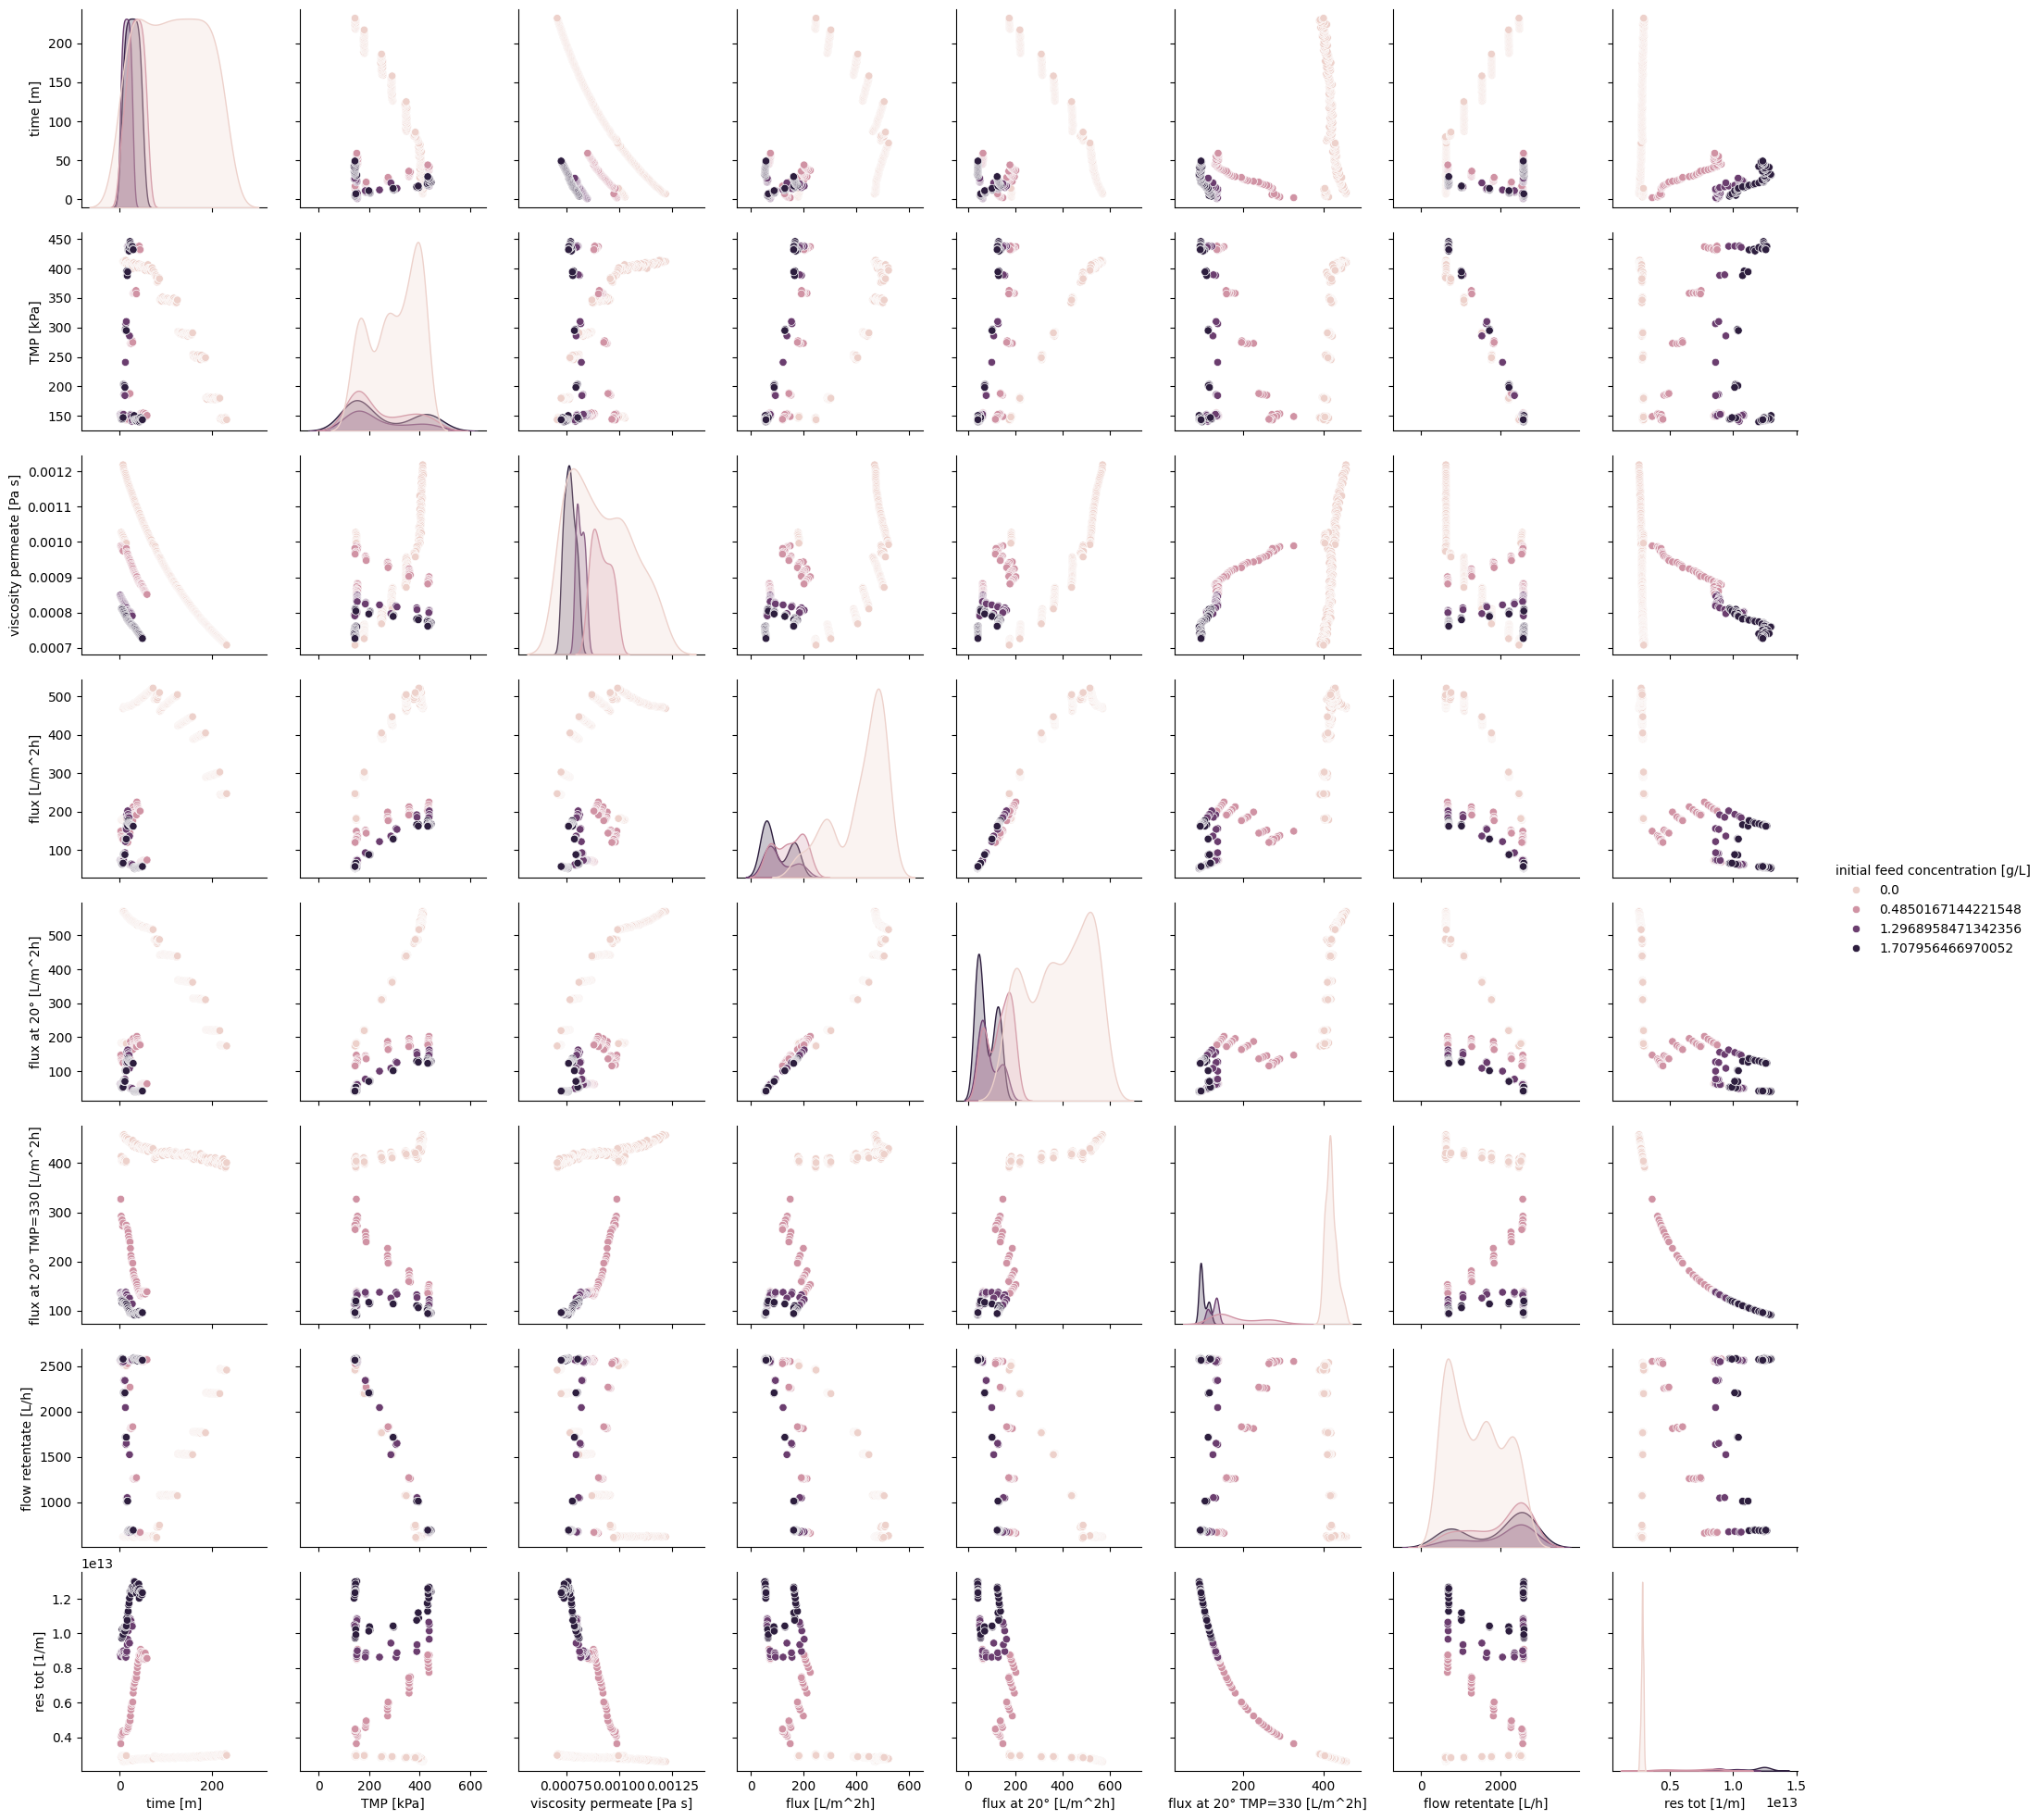

In [54]:
if plot_scatterplot_matrix :
    hue = None
    corr_cols = [
        'time [m]', 'TMP [kPa]', 'viscosity permeate [Pa s]', 'flux [L/m^2h]', f'flux at 20° [L/m^2h]', f'flux at 20° TMP={cur_TMP} [L/m^2h]', 
        'flow retentate [L/h]', 'res tot [1/m]', 
    ]
    if len(conc_lines) > 1 :
        # at least two concentrations
        hue = 'initial feed concentration [g/L]'
        corr_cols.append('initial feed concentration [g/L]')
    sn.pairplot(df_plot[corr_cols], hue=hue)

In [15]:
#############################
# DISPLAY df_all
n = len(df_plot)
pd.set_option('display.max_rows', n)
print("file:", cur_file)
print("data rows:", n)
print("date:", DATE)

file: 2023-11-08 0 clean water.csv
data rows: 224
date: 2023-11-08


In [16]:
#################################
# PLOTS

In [17]:
# choose setting
TIME_IDX  = ROW_IDX_AS_TIME

In [18]:
# c = 'temperature [°C]'
# y_dict = {
#     c  : df_all[c]
# }
# df_JMP = df_all[df_all['jumped temperature'] == 1]
# df_CST = df_ON[df_ON['changed TMP'] == 0]
# COLOR_STR = 'gold'
# COLOR_INC = 'green'
# COLOR_DEC = 'red'
# COLOR_CST = 'blue'
# OF_COLOR = 'black'
# ON_COLOR = 'green'
# fig, ax = plot.subplots(figsize=(15,7))
# if not drop_off_rows :
#     ax.scatter(df_OF[x_axis[TIME_IDX]], df_OF[c], color=OF_COLOR,  marker='o', label='OFF')
# ax.plot(df_plot[x_axis[TIME_IDX]], df_plot[c], color='black') #, linestyle='--')
# ax.scatter(df_CST[x_axis[TIME_IDX]], df_CST[c], color=COLOR_CST,  marker='o', label='CST')
# ax.scatter(df_JMP[x_axis[TIME_IDX]], df_JMP[c], color=COLOR_STR,  marker='o', label='STR')
# #ax.scatter(df_ON[x_axis[TIME_IDX]], df_ON[c], color=ON_COLOR,  marker='o', label='ON')

# if x_format[TIME_IDX] != None :
#     xformatter = mdates.DateFormatter(x_format[TIME_IDX])
#     plot.gcf().axes[0].xaxis.set_major_formatter(xformatter)
# title = f'{c} over Time'
# plot.title(title)
# plot.legend()
# plot.grid()
# print(DATE)
# plot.show()

In [19]:
if False :
    x_col = x_axis[TIME_IDX]
    y_col = 'TMP [kPa]'
    y_dict = {
        y_col  : df_all[y_col]
    }
    df_INC = df_ON[df_ON['increased TMP'] == 1][[x_col, y_col]]
    df_DEC = df_ON[df_ON['decreased TMP'] == 1][[x_col, y_col]]
    df_STRT = df_ON[df_ON['starting'] == 1][[x_col, y_col]]
    df_CONST = df_ON[df_ON['changed TMP'] == 0][[x_col, y_col]]
    COLOR_STRT = 'gold'
    COLOR_INC = 'green'
    COLOR_DEC = 'red'
    COLOR_CONST = 'blue'
    OF_COLOR = 'black'
    ON_COLOR = 'green'
    fig, ax = plot.subplots(figsize=(15,7))
    ax.plot(df_plot[x_col], df_plot[y_col], color='black') #, linestyle='--')
    ax.scatter(df_CONST[x_col], df_CONST[y_col], color=COLOR_CONST,  marker='o', label='CONSTANT')
    ax.scatter(df_INC[x_col], df_INC[y_col], color=COLOR_INC,  marker='o', label='INCREMENT')
    ax.scatter(df_DEC[x_col], df_DEC[y_col], color=COLOR_DEC,  marker='o', label='DECREMENT')
    ax.scatter(df_STRT[x_col], df_STRT[y_col], color=COLOR_STRT,  marker='o', label='START')
    #ax.scatter(df_ON[x_col], df_ON[y_col], color=ON_COLOR,  marker='o', label='ON')
    if not drop_off_rows :
        ax.scatter(df_OF[x_col], df_OF[y_col], color=OF_COLOR,  marker='o', label='OFF')

    if x_format != None :
        xformatter = mdates.DateFormatter(x_axis[TIME_IDX])
        plot.gcf().axes[0].xaxis.set_major_formatter(xformatter)
    title = f'{y_col} over Time'
    plot.title(title)
    plot.legend()
    plot.grid()
    print(DATE)
    plot.show()
    del(df_INC, df_DEC, df_STRT, df_CONST)
    del(COLOR_STRT, COLOR_INC, COLOR_DEC, COLOR_CONST, OF_COLOR, ON_COLOR)

(<Axes: xlabel='index', ylabel='resistance [1/m]'>,
 <Axes: title={'center': 'Resistance and TMP over Time'}, ylabel='pressure [kPa]'>)

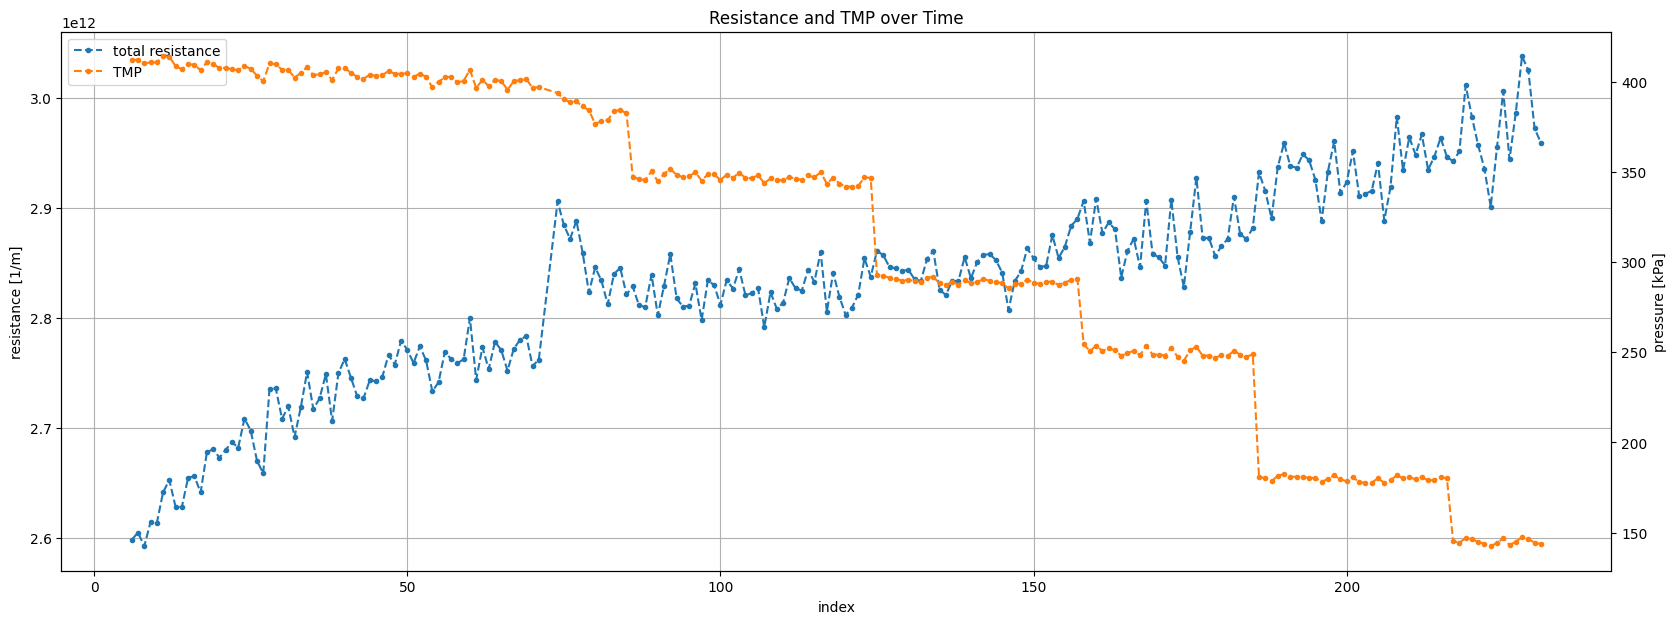

In [20]:
y_dict = {
    'total resistance'   : df_plot['res tot [1/m]'],
    'TMP'                : df_plot['TMP [kPa]'],
}
y_ax_lbl = ['resistance [1/m]', 'pressure [kPa]']
title    = 'Resistance and TMP over Time'
plot_time_series_2_axis(x=df_plot[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl=y_ax_lbl, title=title, x_format=x_format[TIME_IDX], secondary_y=['TMP'])


Variance Inflation Factor (VIF)
 - The model has just one variable, index, thus there can't be multicollinerity.

Intercept:    442.35785031710293
Coefficients: [-0.19121715487118085]
                                 OLS Regression Results                                 
Dep. Variable:     flux at 20° TMP=330 [L/m^2h]   R-squared:                       0.850
Model:                                      OLS   Adj. R-squared:                  0.850
Method:                           Least Squares   F-statistic:                     1261.
Date:                          Mon, 17 Jun 2024   Prob (F-statistic):           1.69e-93
Time:                                  06:45:59   Log-Likelihood:                -689.16
No. Observations:                           224   AIC:                             1382.
Df Residuals:                               222   BIC:                             1389.
Df Model:                                     1                                         
Covariance Type

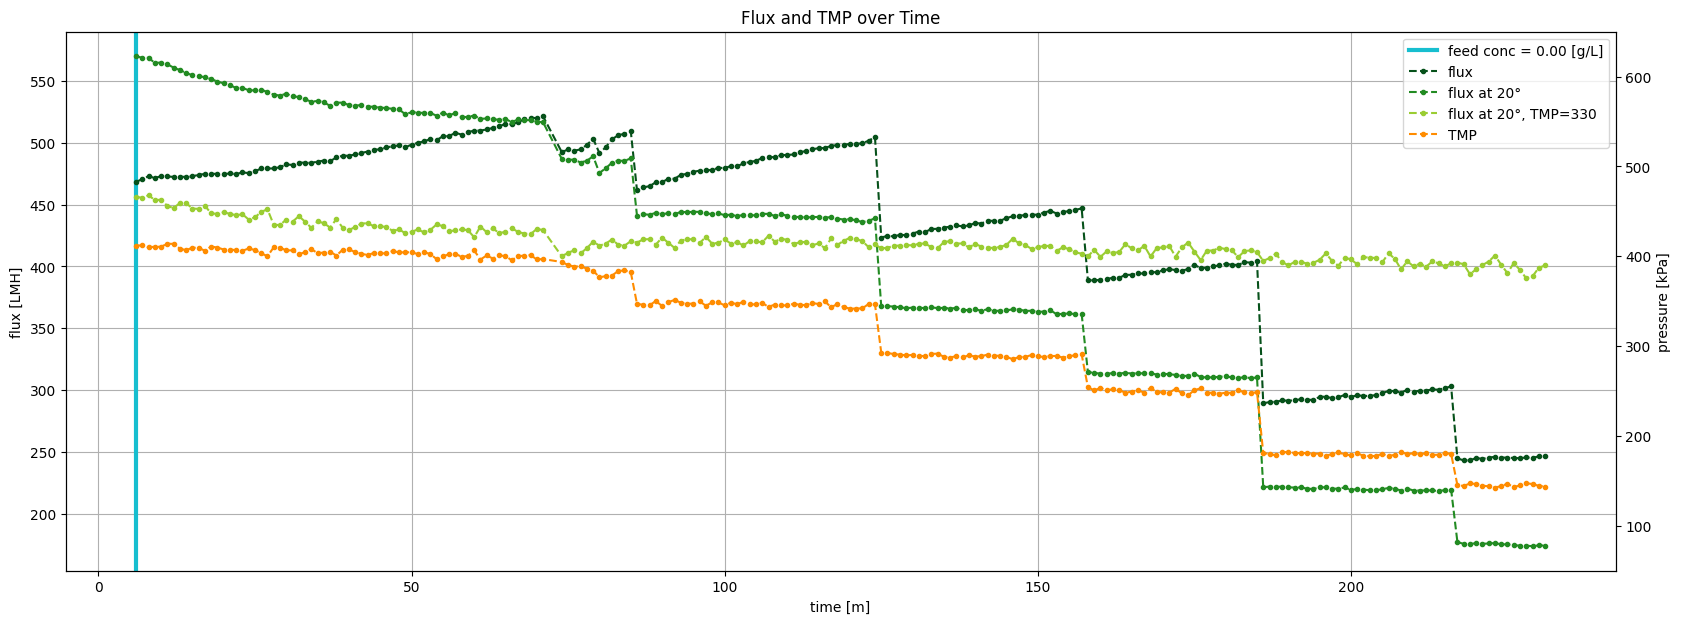

In [21]:
x_cols = ['index']
x = df_plot[x_cols]
y_col = f'flux at 20° TMP={cur_TMP} [L/m^2h]'
y = df_plot[y_col]
model, y_pred, intercept, coeffs = call_linear_model(x, y)
print(f"\np-values:\n{model.pvalues}\n")
print(get_error_stats(y, y_pred, y_col))
print()
compute_error_metrics(y, y_pred)

y_dict = {
    'flux' : df_plot['flux [L/m^2h]'],
    'flux at 20°' : df_plot['flux at 20° [L/m^2h]'],
    f'flux at 20°, TMP={cur_TMP}' : df_plot[f'flux at 20° TMP={cur_TMP} [L/m^2h]'],
    #y_col + ' pred'  : y_pred,
    'TMP'  : df_plot['TMP [kPa]'],

}
title  = 'Flux and TMP over Time'
ax1, ax2 = plot_time_series_2_axis(x=df_plot[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl='time [m]', y_ax_lbl=['flux [LMH]', 'pressure [kPa]'], title=title, x_format=x_format[TIME_IDX], secondary_y=['TMP', 'retentate prs'], concentration_lines=conc_lines
                        , color=['#06511A','forestgreen', 'yellowgreen','darkorange']) #'black', 'darkgrey', 'lightgrey', 'green'])
ax2.set_ylim(50,650)
if cur_file == '2023-11-08 0 clean water.csv' :
    plot.savefig(f'{PATH_IMAGES}/flux_of_clear_water_vs_tmp.png')
if cur_file == 'ALL_DATA.csv' :
    plot.savefig(f'{PATH_IMAGES}/flux_of_dirty_water_vs_tmp.png')

(<Axes: xlabel='index', ylabel='flux [L/m^2h]'>,
 <Axes: title={'center': 'Flux and Resistance over Time'}, ylabel='temperature [°C]'>)

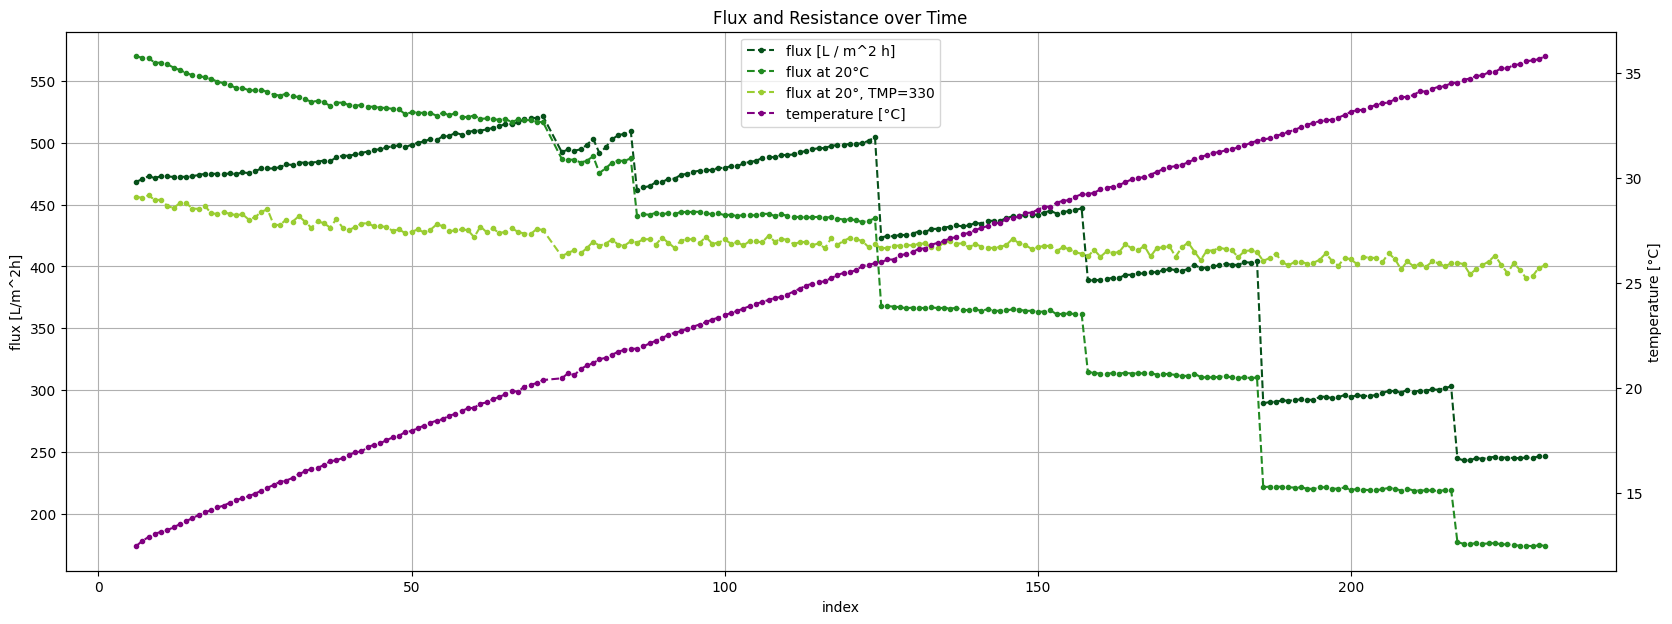

In [22]:
y_dict = {
    'flux [L / m^2 h]' : df_plot['flux [L/m^2h]'],
    'flux at 20°C' : df_plot['flux at 20° [L/m^2h]'],
    f'flux at 20°, TMP={cur_TMP}' : df_plot[f'flux at 20° TMP={cur_TMP} [L/m^2h]'],
    'temperature [°C]' : df_plot['temperature [°C]'],
}
y_ax_lbl = 'flux [LMH]'
title    = 'Flux and Resistance over Time'
plot_time_series_2_axis(x=df_plot[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl=['flux [L/m^2h]', 'temperature [°C]'], title=title, x_format=x_format[TIME_IDX], secondary_y=['temperature [°C]'], loc='upper center'
                        , color=['#06511A','forestgreen', 'yellowgreen','purple'])

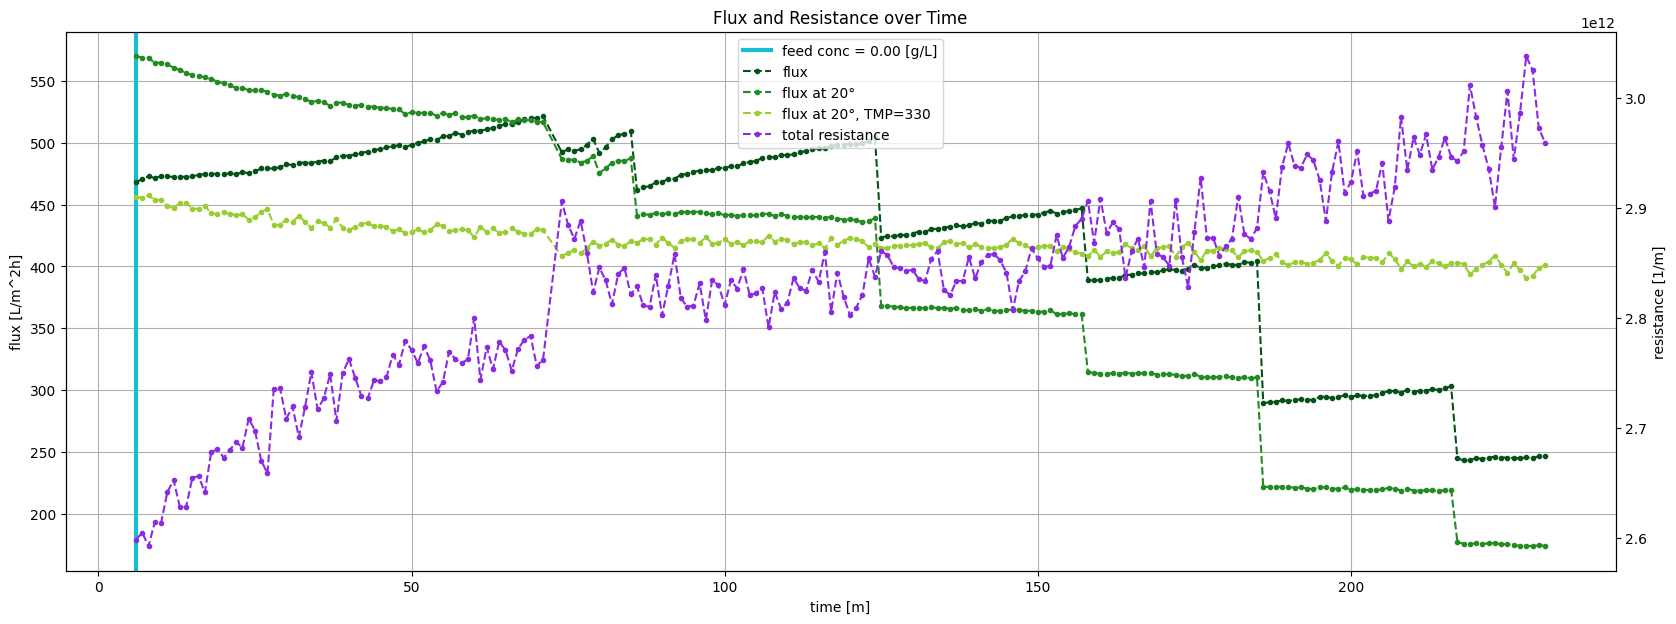

In [23]:
y_dict = {
    'flux' : df_plot['flux [L/m^2h]'],
    'flux at 20°' : df_plot['flux at 20° [L/m^2h]'],
    f'flux at 20°, TMP={cur_TMP}' : df_plot[f'flux at 20° TMP={cur_TMP} [L/m^2h]'],
    'total resistance' : df_plot['res tot [1/m]'],
}
y_ax_lbl = 'flux [LMH]'
title    = 'Flux and Resistance over Time'
ax1, ax2 = plot_time_series_2_axis(x=df_plot[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl='time [m]', y_ax_lbl=['flux [L/m^2h]', 'resistance [1/m]'], title=title, x_format=x_format[TIME_IDX], secondary_y=['total resistance', 'total resistance at 20°C'], loc='upper center'
, color=['#06511A','forestgreen', 'yellowgreen','blueviolet'],concentration_lines=conc_lines)
if cur_file == '2023-11-08 0 clean water.csv' :
    plot.savefig(f'{PATH_IMAGES}/flux_of_clear_water_vs_res.png')
if cur_file == 'ALL_DATA.csv' :
    ax1.legend(bbox_to_anchor=(0.4,1))
    plot.savefig(f'{PATH_IMAGES}/flux_of_dirty_water_vs_res.png')

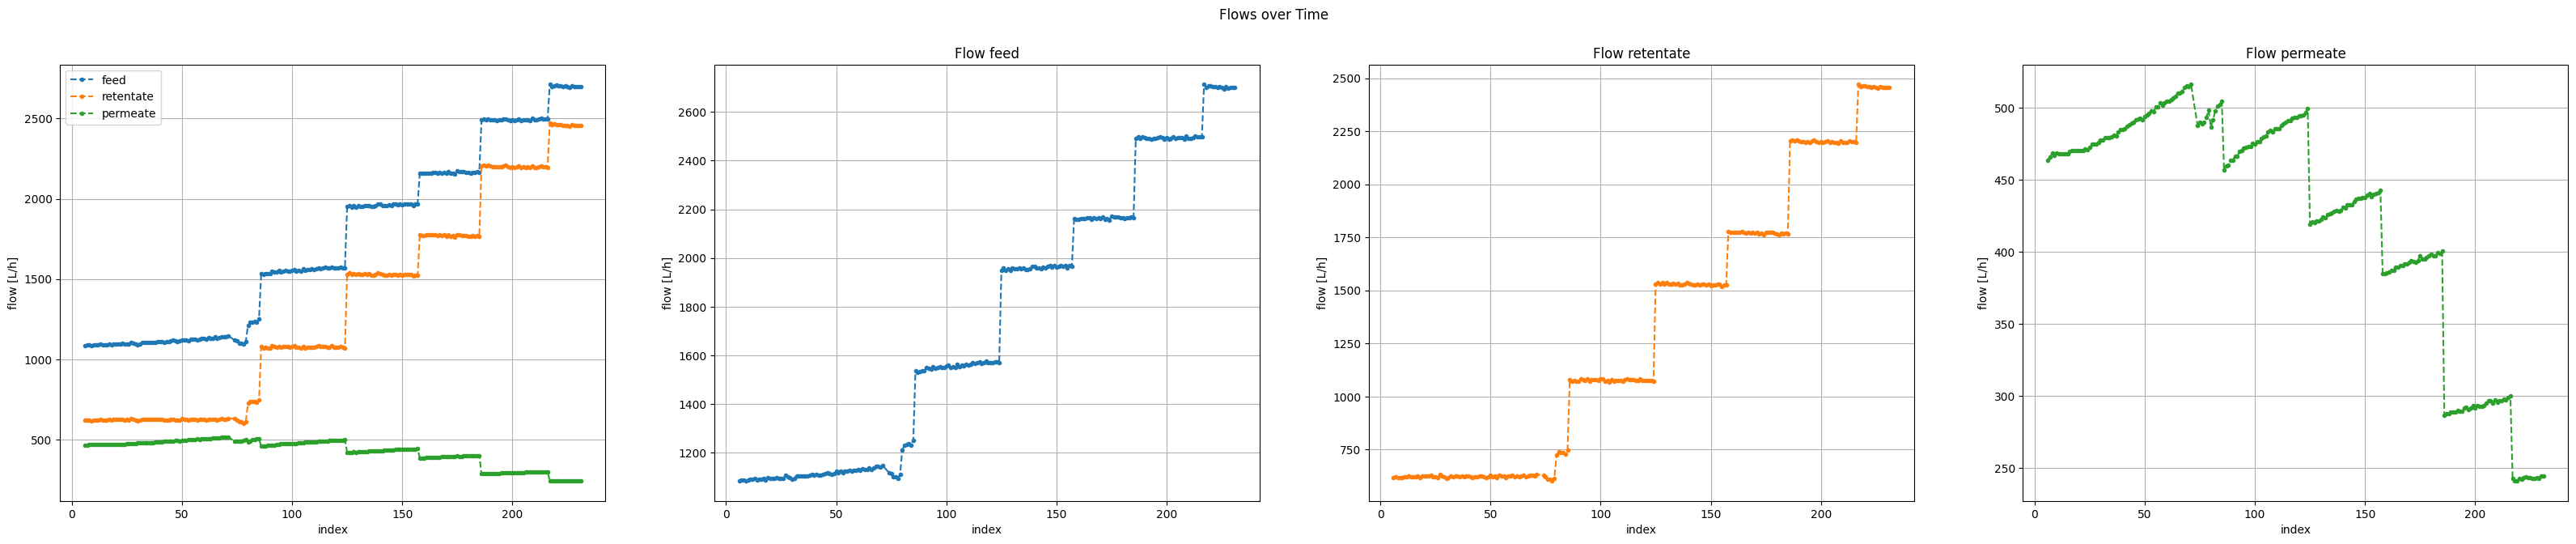

In [24]:
y_dict = {
    'feed'          : df_plot['flow feed [L/h]'],
    'retentate'     : df_plot['flow retentate [L/h]'],
    'permeate'      : df_plot['flow permeate [L/h]']
}
y_ax_lbl = 'flow [L/h]'
title = None

rows = 1
cols = 4
fig, axs = plot.subplots(rows, cols, figsize=(10*cols, 7*rows))
plot_time_series_1_axis(x=df_plot[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl=y_ax_lbl, title=title, x_format=x_format[TIME_IDX], cur_ax=axs[0])
i = 0
j = 1
for (prs, col) in y_dict.items() :
    y_dict_tmp = {}
    y_dict_tmp[prs] = col
    plot_time_series_1_axis(x=df_plot[x_axis[TIME_IDX]], y_series=y_dict_tmp, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl=y_ax_lbl, title="Flow "+prs, x_format=x_format[TIME_IDX], cur_ax=axs[j], color=[COLOR_CYCLE[i*cols+j-1]]
    )
    j = (j + 1) % cols
    if j == 0 :
        i += 1
plot.suptitle('Flows over Time')
plot.show()


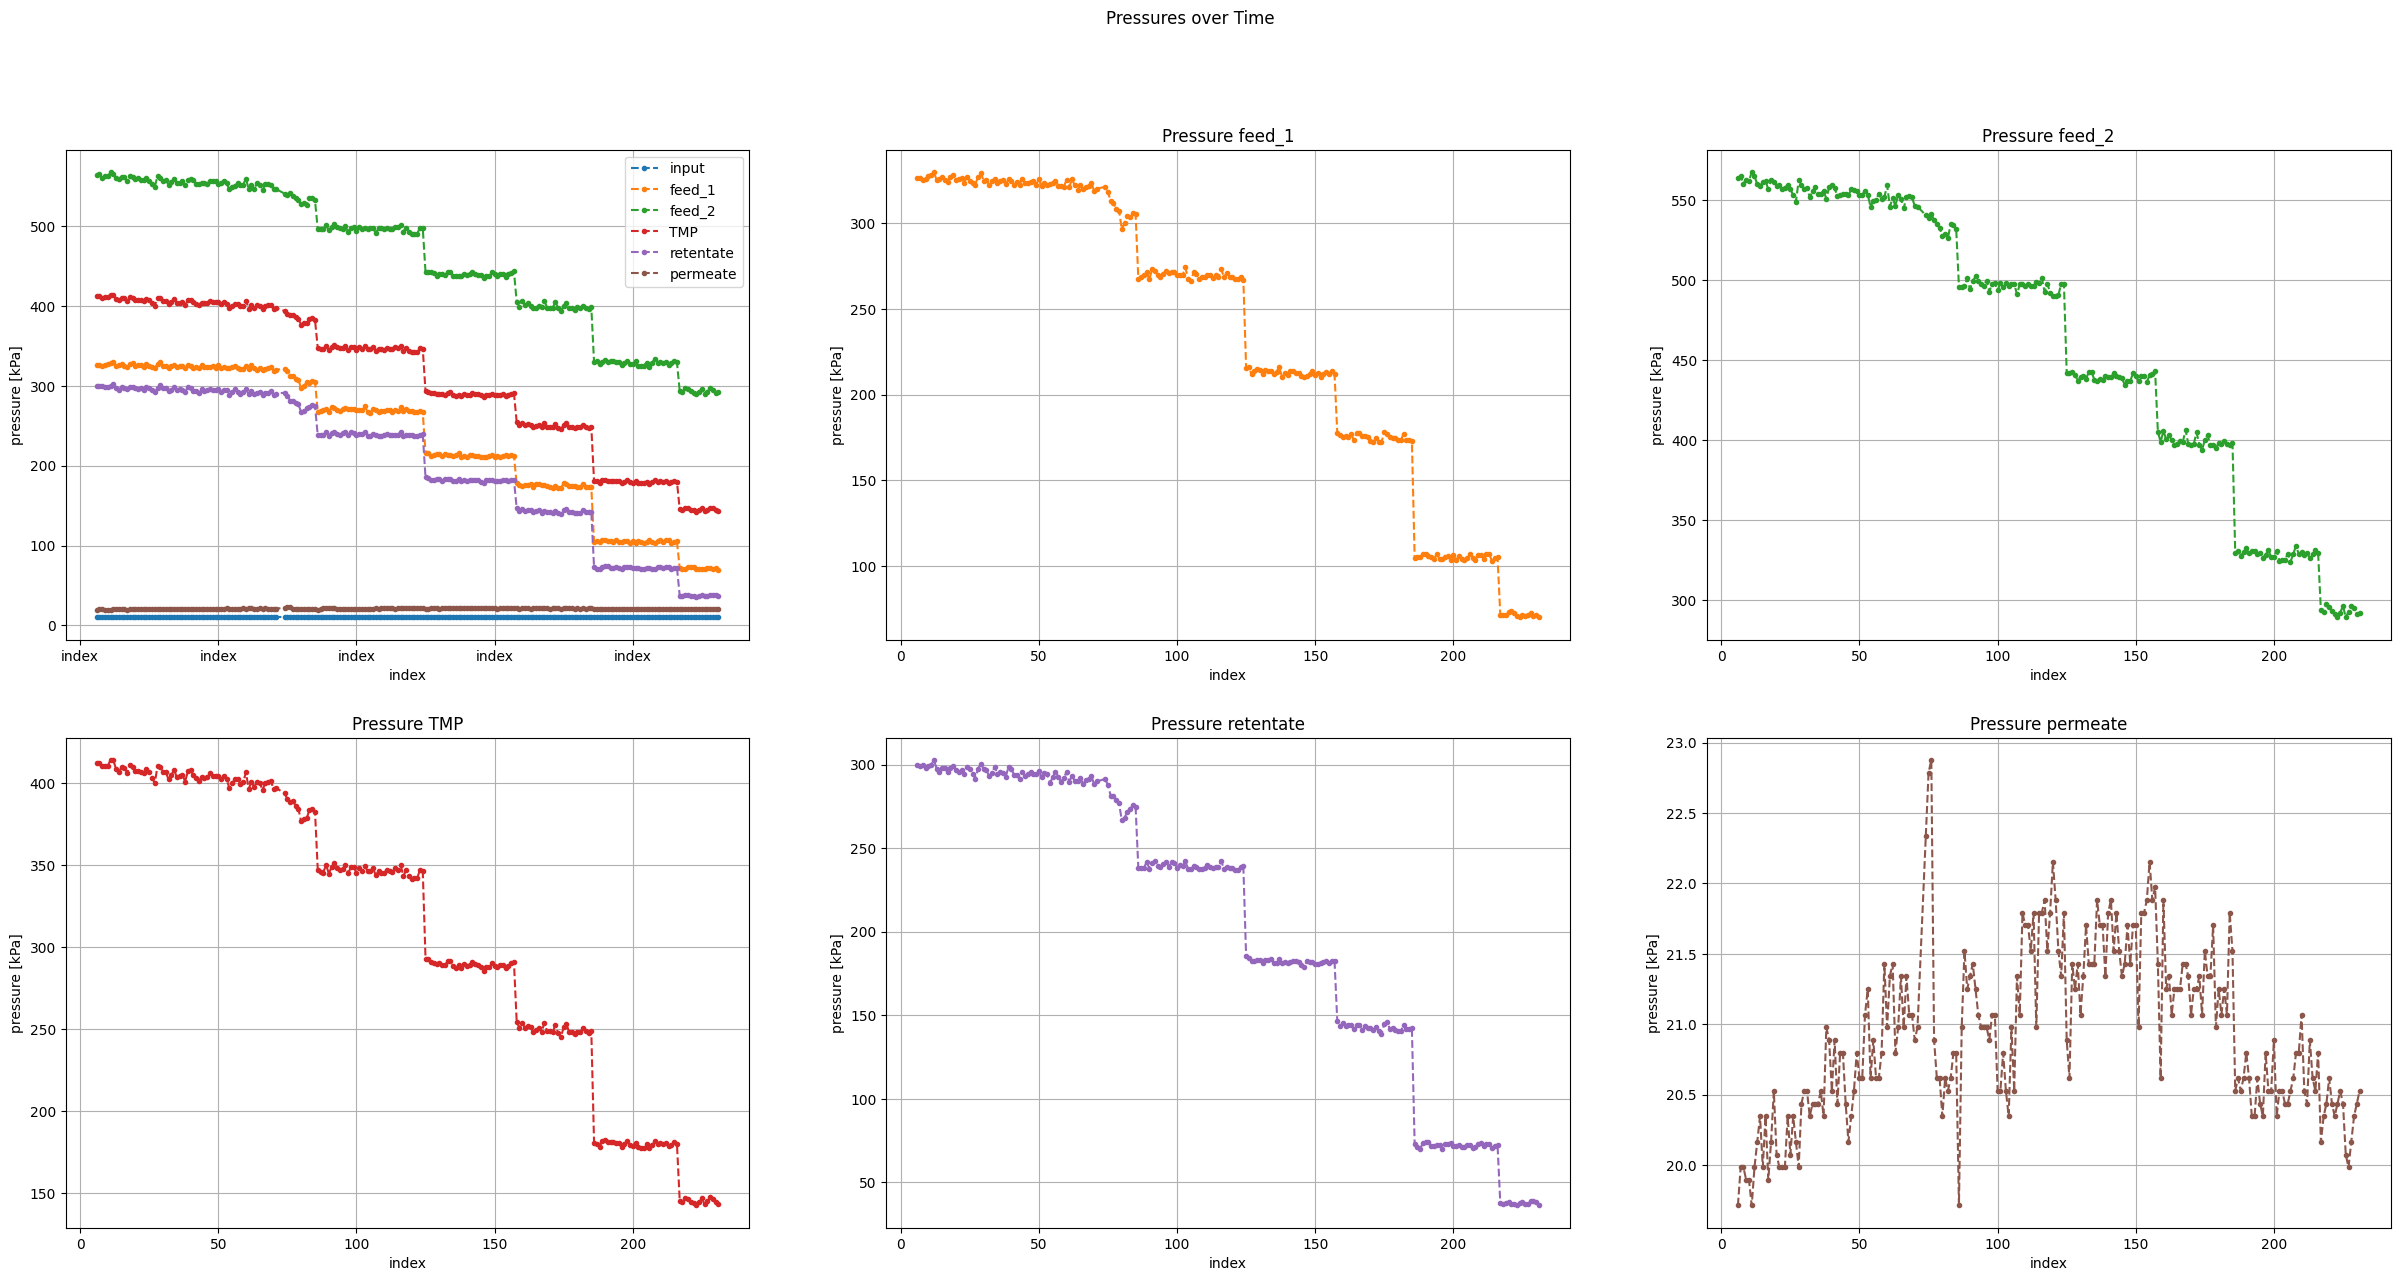

In [25]:
y_dict = {
    'input'     : df_plot['prs input [kPa]'],
    'feed_1'    : df_plot['prs feed_1 [kPa]'],
    'feed_2'    : df_plot['prs feed_2 [kPa]'],
    'TMP'       : df_plot['TMP [kPa]'],
    'retentate' : df_plot['prs retentate [kPa]'],
    'permeate'  : df_plot['prs permeate [kPa]'],
}
y_ax_lbl = 'pressure [kPa]'
title = None
rows = 2
cols = 3
fig, axs = plot.subplots(rows, cols, figsize=(10*cols, 7*rows))
plot_time_series_1_axis(x=df_plot[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl=y_ax_lbl, title=title, x_format=x_axis[TIME_IDX], cur_ax=axs[0, 0])
i = 0
j = 1
for (prs, col) in y_dict.items() :
    if (prs != 'input') :
        y_dict_tmp = {}
        y_dict_tmp[prs] = col
        plot_time_series_1_axis(x=df_plot[x_axis[TIME_IDX]], y_series=y_dict_tmp, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl=y_ax_lbl, title="Pressure "+prs, x_format=x_format[TIME_IDX], cur_ax=axs[i, j], color=[COLOR_CYCLE[i*cols+j]])
        j = (j + 1) % cols
        if j == 0 :
            i += 1
plot.suptitle('Pressures over Time')
plot.show()


In [26]:
get_summary(df_plot, ['prs permeate [kPa]'], stats=["min", "median", "mean",  "max", "var", "std"], conf_int=0.95)

,prs permeate [kPa]
mean,20.926746
min,19.712100
max,22.876900
var,0.355525
std,0.596259
median,20.887600
ci_0.95_low,20.848236
ci_0.95_high,21.005255


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

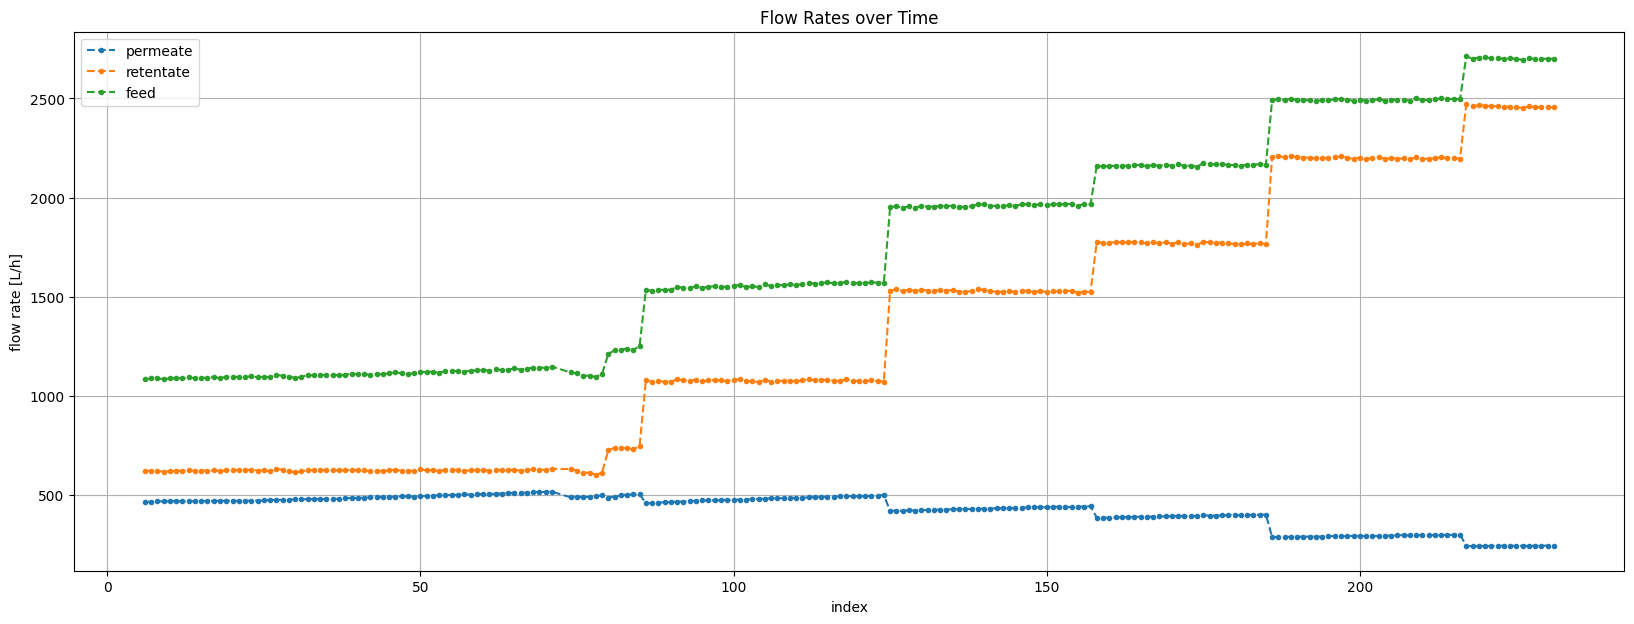

In [27]:
y_dict = {
    'permeate'  : df_plot['flow permeate [L/h]'],
    'retentate' : df_plot['flow retentate [L/h]'],
    'feed'      : df_plot['flow feed [L/h]']
}
title='Flow Rates over Time'
y_ax_lbl='flow rate [L/h]'
plot_time_series_1_axis(x=df_plot[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl=y_ax_lbl, title=title, x_format=x_format[TIME_IDX])


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

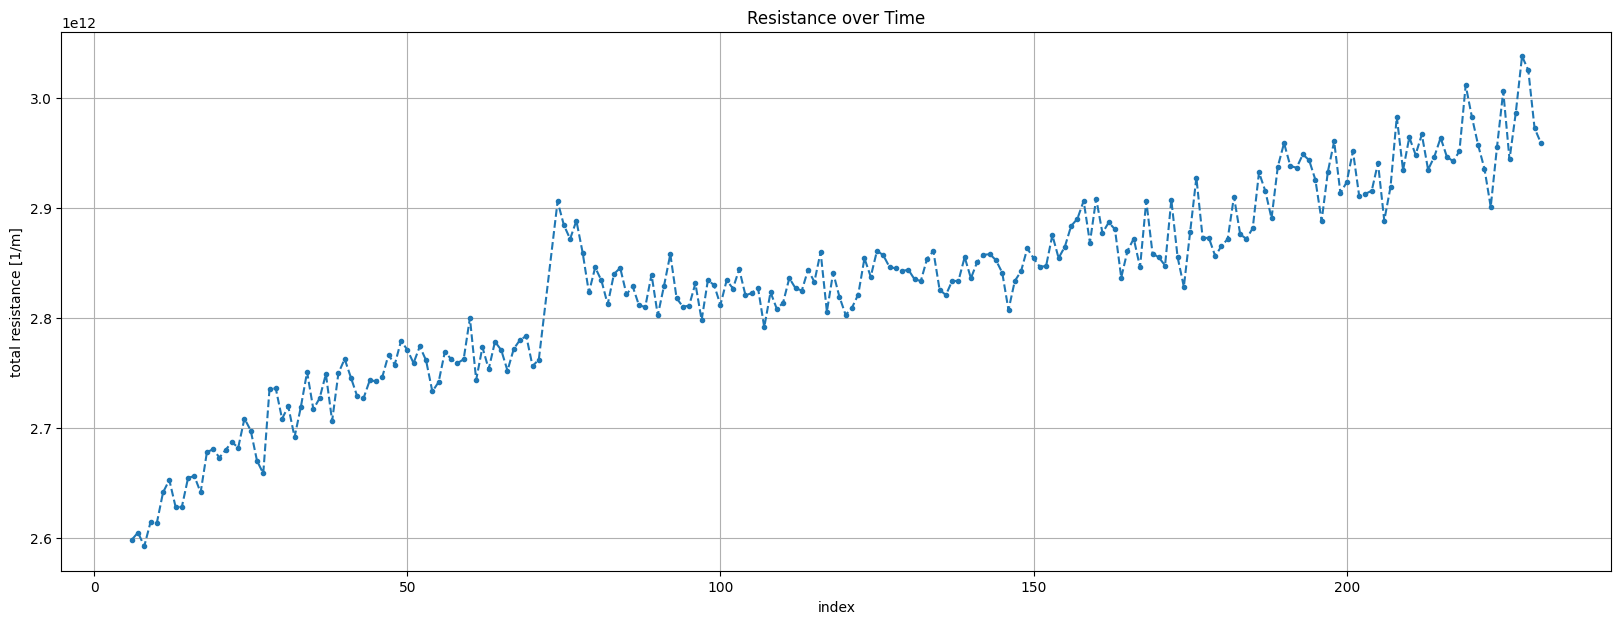

In [28]:
y_dict = {
    'total resistance'  : df_plot['res tot [1/m]']
}
#plot.ylim((1.5e12, 1.6e13))
x = df_plot['time [m]']
y = df_plot['res tot [1/m]']
#plot.plot(df_plot[x_axis[TIME_IDX]], smooth_data_lowess(x, y, 0.3), lw=1.5, zorder=10, c='darkred')

title='Resistance over Time'
y_ax_lbl='total resistance [1/m]'
plot_time_series_1_axis(x=df_plot[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl=y_ax_lbl, title=title, x_format=x_format[TIME_IDX])

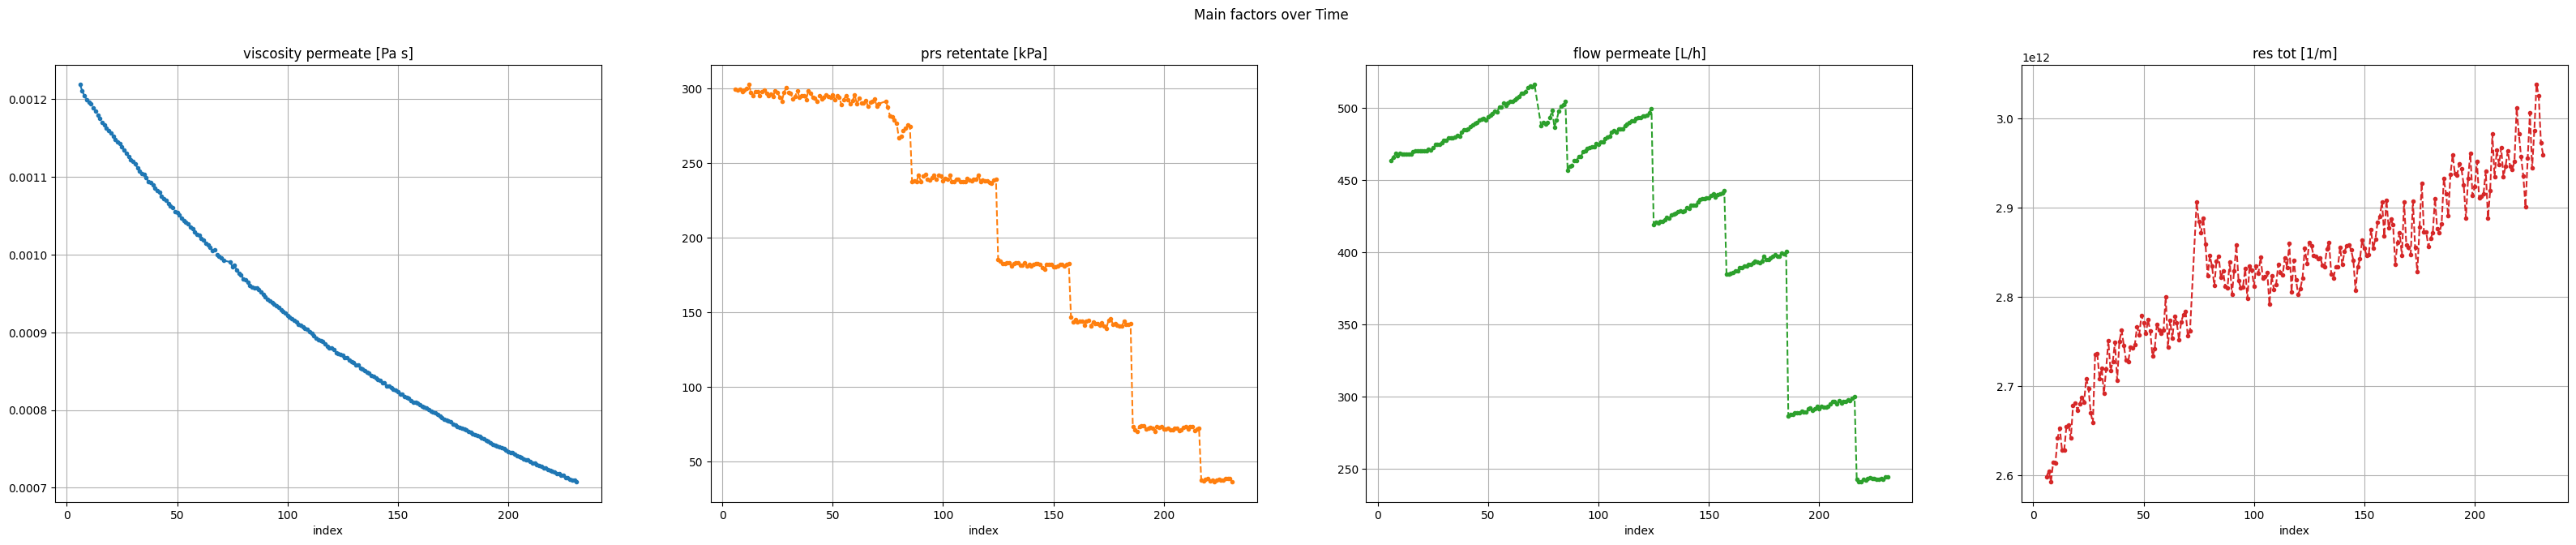

In [29]:
y_dict = {
    'viscosity permeate [Pa s]'     : df_plot['viscosity permeate [Pa s]'],
    'prs retentate [kPa]'    : df_plot['prs retentate [kPa]'],
    'flow permeate [L/h]'    : df_plot['flow permeate [L/h]'],
    'res tot [1/m]'       : df_plot['res tot [1/m]'],
}
y_ax_lbl = None
title = None
rows = 1
cols = 4
fig, axs = plot.subplots(rows, cols, figsize=(10*cols, 7*rows))
i = 0
j = 0
for (prs, col) in y_dict.items() :
    if (prs != 'input') :
        y_dict_tmp = {}
        y_dict_tmp[prs] = col
        plot_time_series_1_axis(x=df_plot[x_axis[TIME_IDX]], y_series=y_dict_tmp, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl=y_ax_lbl, title=prs, x_format=x_format[TIME_IDX], cur_ax=axs[j], color=[COLOR_CYCLE[i*cols+j]])
        j = (j + 1) % cols
        if j == 0 :
            i += 1
plot.suptitle('Main factors over Time')
plot.show()

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

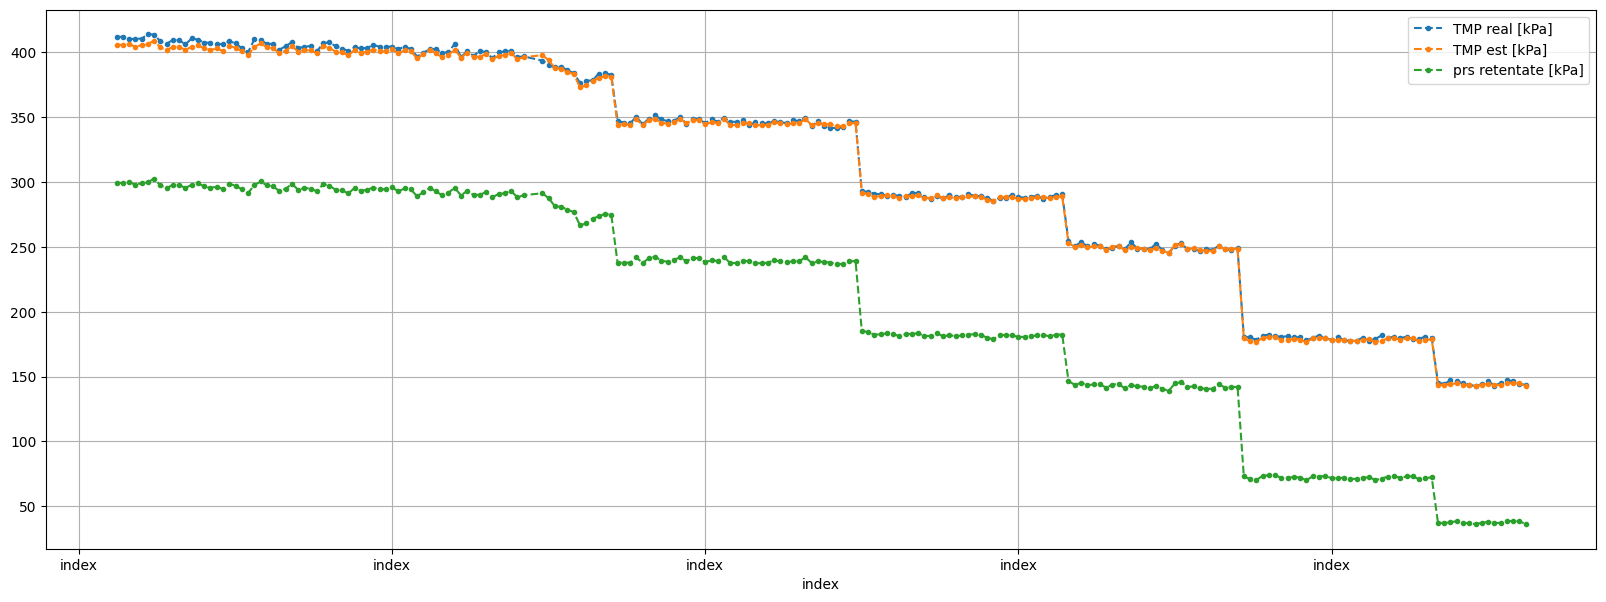

In [30]:
df_plot['prs prmt est [kPa]'] = 23.55
df_plot['prs feed_2 est [kPa]'] = predict_y(df_plot['prs retentate [kPa]'], 260, [1])
df_plot['TMP est [kPa]'] = 0.5 * (df_plot['prs retentate [kPa]'] + df_plot['prs feed_2 est [kPa]']) - df_plot['prs prmt est [kPa]']
y_dict = {
    'TMP real [kPa]'  : df_plot['TMP [kPa]'] ,
    'TMP est [kPa]'   : df_plot['TMP est [kPa]'] ,
    'prs retentate [kPa]' : df_plot['prs retentate [kPa]']
}
plot_time_series_1_axis(x=df_plot[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl=y_ax_lbl, title=title, x_format=x_axis[TIME_IDX])

(<Axes: xlabel='index', ylabel='vlct crsflow [m/s]'>,
 <Axes: title={'center': 'vlct crsflow vs TMP'}, ylabel='TMP [kPa]'>)

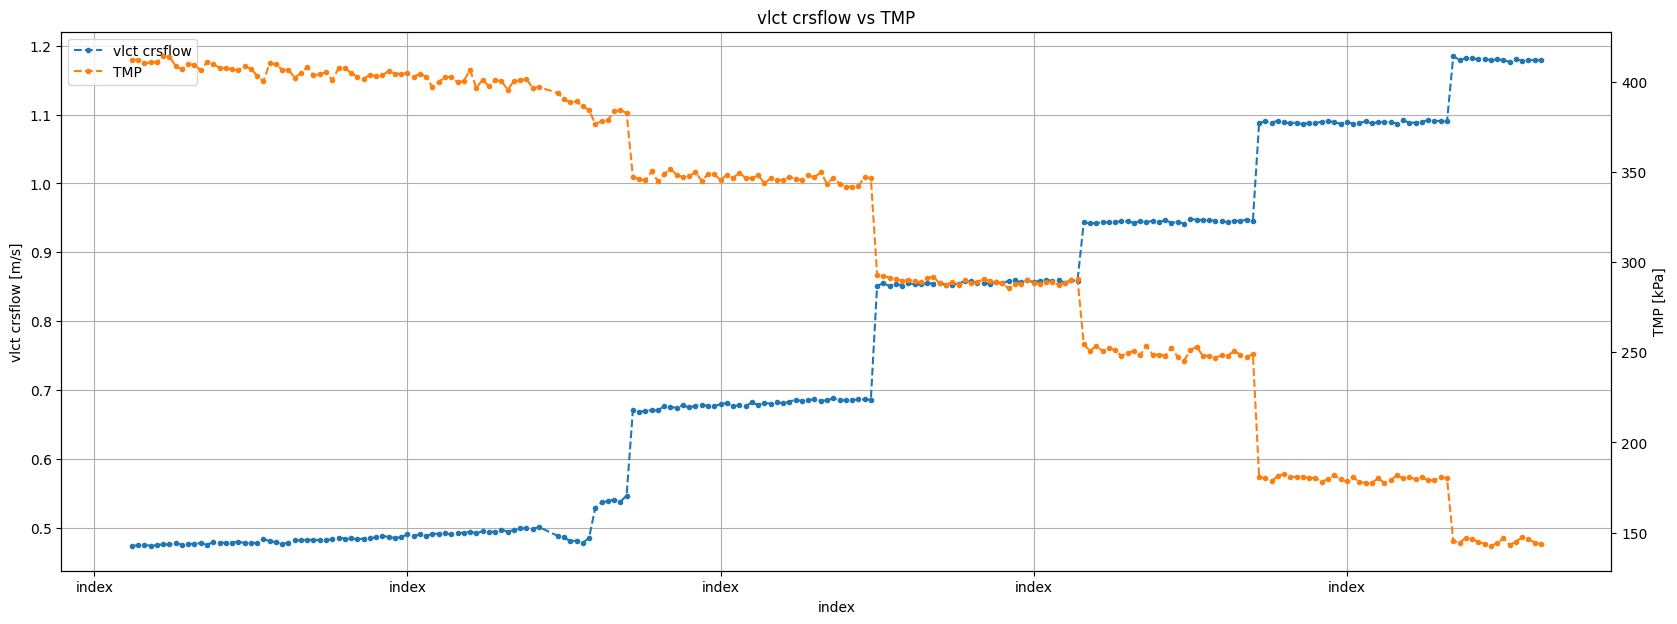

In [31]:
# CALCULATING CROSSFLOW VELOCITY
mbn_num = 3
mbn_channels = 30
mbn_channel_dim =  0.003
membrane_section = mbn_channels * mbn_num * (mbn_channel_dim/2)**2 * math.pi
# print("crossflow velocity included!")
cur_df = df_plot
# vlct_crsflow = liters__to__m3(flow_feed) / (area_tot * SECS_PER_HRS);
area_tot = mbn_num * 0.33
mbn_diam = mbn_num * 0.025
mbn_len  = 1.178

#                    [m/s]   =  [m^3 / h]                           / [m^2]
cur_df['vlct crsflow [m/s]'] = (cur_df['flow feed [L/h]'] / (1000 * 3600.0)) / membrane_section
#                    [L/h]   =  [m^3 / h]                           / [m^2]
cur_df['flow retentate est [L/h]'] = 1.25 * 0.25 * math.pi * (3600 * cur_df['vlct crsflow [m/s]']) * mbn_diam**2 * mbn_len * mbn_channels * mbn_num
#cur_df['dis'] = cur_df['flow retentate [L/h]'] / cur_df['flow retentate est [L/h]']

y_dict = {
    'vlct crsflow' : df_plot['vlct crsflow [m/s]'],
    'TMP' : df_plot['TMP [kPa]']
}
y_ax_lbl = ['vlct crsflow [m/s]', 'TMP [kPa]']
plot_time_series_2_axis(x=cur_df[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl=y_ax_lbl, title='vlct crsflow vs TMP', x_format=x_axis[TIME_IDX], secondary_y=['TMP'])

Variance Inflation Factor (VIF)
 - The model has just one variable, flow retentate est [L/h], thus there can't be multicollinerity.

Intercept:    -658.9074654256935
Coefficients: [1.233661820713797]
                             OLS Regression Results                             
Dep. Variable:     flow retentate [L/h]   R-squared:                       0.997
Model:                              OLS   Adj. R-squared:                  0.997
Method:                   Least Squares   F-statistic:                 8.458e+04
Date:                  Mon, 17 Jun 2024   Prob (F-statistic):          1.32e-288
Time:                          06:46:14   Log-Likelihood:                -1097.2
No. Observations:                   224   AIC:                             2198.
Df Residuals:                       222   BIC:                             2205.
Df Model:                             1                                         
Covariance Type:              nonrobust                                

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

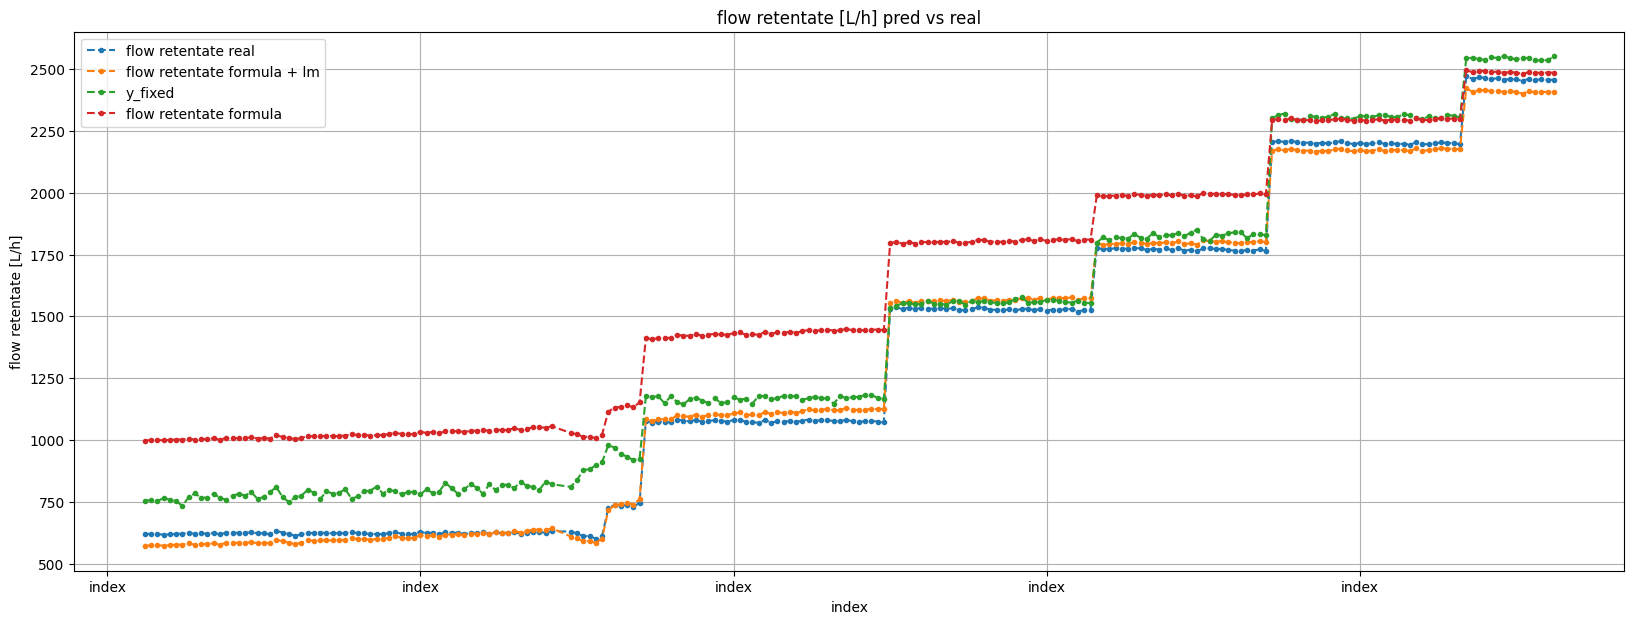

In [32]:
# ESTIMATING RETENTATE FLOW
# TODO TO IMPROVE.. include conc_feed [g/L] !
#cur_df = df_plot

#cur_df = cur_df[cur_df['time [m]'] >  2]
#cur_df = cur_df[cur_df['time [m]'] < 20]
#x = cur_df[['prs retentate [kPa]']] #, 'res tot [1/m]', 'viscosity permeate [Pa s]', 'flow permeate [L/h]'
x = cur_df[['flow retentate est [L/h]']] #, 'res tot [1/m]', 'viscosity permeate [Pa s]', 'flow permeate [L/h]'
y_col = 'flow retentate [L/h]'
y = cur_df[y_col]
model, y_pred, intercept, coeffs = call_linear_model(x, y)
#y_fixed_0 = predict_y(cur_df[['prs retentate [kPa]']], 2765.4113, [-7.18504302])
#y_fixed_5 = predict_y(cur_df[['prs retentate [kPa]']], 2830.8970, [-6.45384645])
#y_fixed   = predict_y(cur_df[['prs retentate [kPa]']], 2798.1541, [-6.81944473]) #average of 0 and 5
y_dict = {
    'flow retentate real'  : y,
    'flow retentate formula + lm'  : y_pred,
    #'y_fixed' : y_fixed,
    #'y fixed 0' : y_fixed_0,
    #'y fixed 5' : y_fixed_5,
    'flow retentate formula' : cur_df['flow retentate est [L/h]']
}
title = y_col + ' pred vs real'
y_ax_lbl=y_col
plot_time_series_1_axis(x=cur_df[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl=y_ax_lbl, title=title, x_format=x_axis[TIME_IDX])

Variance Inflation Factor (VIF)
 - The model has just one variable, prs retentate [kPa], thus there can't be multicollinerity.

Intercept:    34.31659586248958
Coefficients: [0.9832366234888685]
                            OLS Regression Results                            
Dep. Variable:       prs feed_1 [kPa]   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.181e+06
Date:                Mon, 17 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:46:15   Log-Likelihood:                -355.99
No. Observations:                 224   AIC:                             716.0
Df Residuals:                     222   BIC:                             722.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
               

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

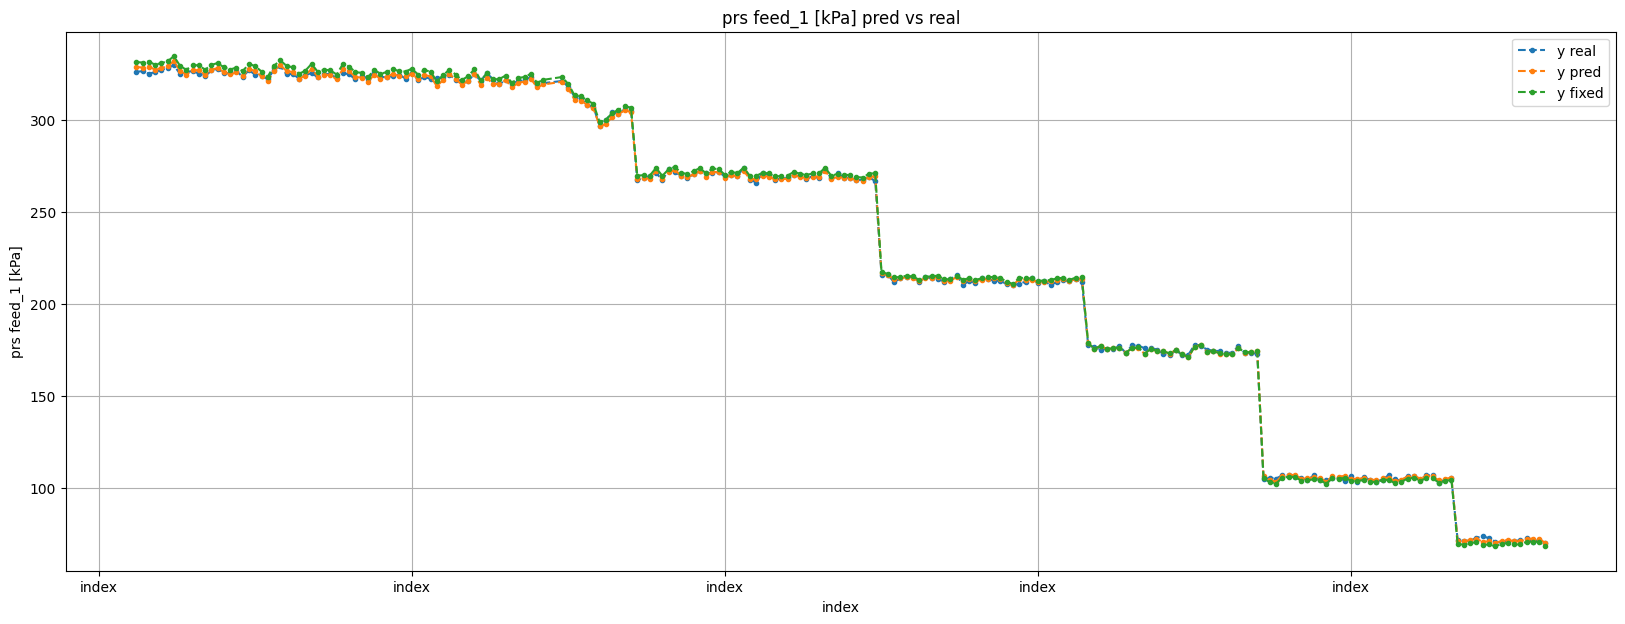

In [33]:
# ESTIMATING PRESSURE PUMP OULET PRESSURE
x = df_plot[['prs retentate [kPa]']]
y_col = 'prs feed_1 [kPa]'
y = df_plot[y_col]
model, y_pred, intercept, coeffs = call_linear_model(x, y)
#y_fixed = predict_y(x, 32, [1])
y_dict = {
    'y real'  : y,
    'y pred'  : y_pred,
    #'y fixed' : y_fixed
}
title = y_col + ' pred vs real'
y_ax_lbl=y_col
plot_time_series_1_axis(x=df_plot[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl=y_ax_lbl, title=title, x_format=x_axis[TIME_IDX])

Variance Inflation Factor (VIF)
 - The model has just one variable, prs retentate [kPa], thus there can't be multicollinerity.

Intercept:    254.82846598512947
Coefficients: [1.0159144984395123]
                            OLS Regression Results                            
Dep. Variable:       prs feed_2 [kPa]   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.607e+05
Date:                Mon, 17 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:46:16   Log-Likelihood:                -532.54
No. Observations:                 224   AIC:                             1069.
Df Residuals:                     222   BIC:                             1076.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
              

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

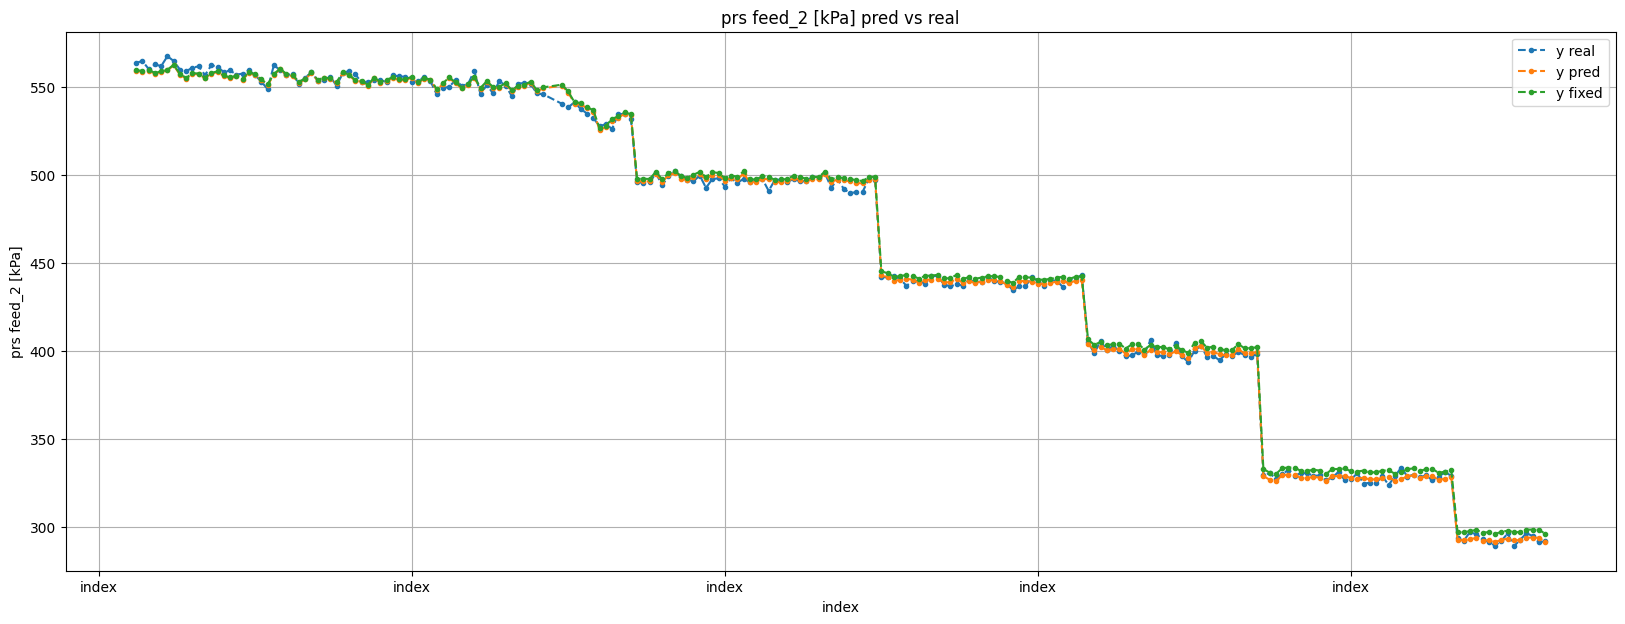

In [34]:
# ESTIMATING CIRCULATION PUMP OULET PRESSURE == FEED PRESSURE ON THE MEMBRANE
x = df_plot[['prs retentate [kPa]']]
y_col = 'prs feed_2 [kPa]'
y = df_plot[y_col]
model, y_pred, intercept, coeffs = call_linear_model(x, y)
y_dict = {
    'y real'  : y,
    'y pred'  : y_pred,
    'y fixed' : predict_y(x, 260, [1])
}
title = y_col + ' pred vs real'
y_ax_lbl=y_col
plot_time_series_1_axis(x=df_plot[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl=y_ax_lbl, title=title, x_format=x_axis[TIME_IDX])

Variance Inflation Factor (VIF)
 - The model has just one variable, time [m], thus there can't be multicollinerity.

Intercept:    8.069310000000003
Coefficients: [1.6492999999999962]
                            OLS Regression Results                            
Dep. Variable:       temperature [°C]   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 17 Jun 2024   Prob (F-statistic):                nan
Time:                        06:46:17   Log-Likelihood:                 63.586
No. Observations:                   2   AIC:                            -123.2
Df Residuals:                       0   BIC:                            -125.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    s

/opt/conda/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/opt/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


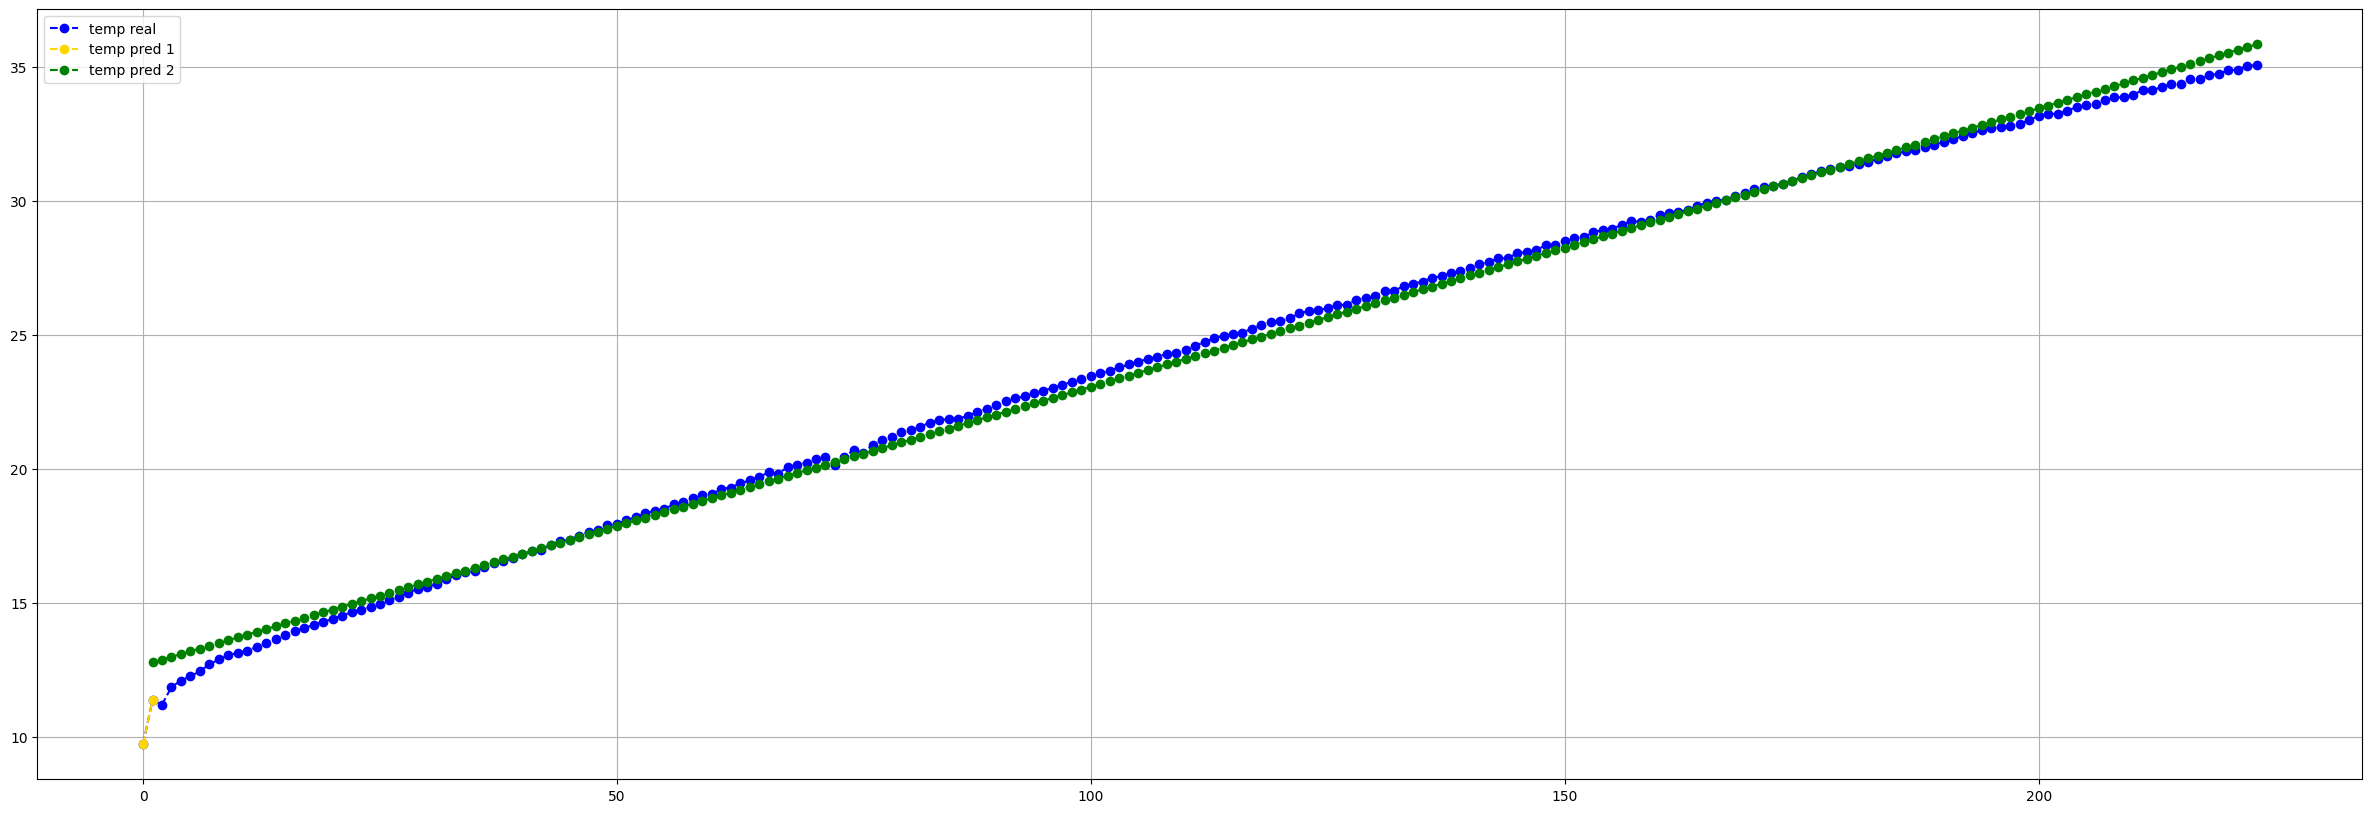

In [35]:
# ESTIMATING TEMPERATURE
if file_idx in [0, 5] :
    df_temp = df_all
    df_temp['filter'] = ((df_plot['jumped temperature'] == 1) | (df_plot['is_ON'] == True))
    df_temp['time [m]'] = df_temp['time [m]'] - df_temp.loc[0, 'time [m]'] + 1
    df_temp = df_temp[df_temp['filter'] == True]

    if file_idx == 0 :
        # clean membrane
        df_init = df_temp[df_temp['time [m]'] <= 2]     #Intercept:     8.06931000000000, Coefficients: [1.6493]
        df_next = df_temp[df_temp['time [m]'] >= 2]     #Intercept:    12.68446247249464, Coefficients: [0.10259717]
    if file_idx == 5 :
        # clean membrane
        df_temp = df_temp[df_temp['time [m]'] <= 23]
        df_init = df_temp[df_temp['time [m]'] <=  2]    #Intercept:    10.89049000000000, Coefficients: [3.85199]
        df_next = df_temp[df_temp['time [m]'] >=  2]    #Intercept:    18.56241843290043, Coefficients: [0.12108152]

    y_col = 'temperature [°C]'
    x1 = df_init[['time [m]']]
    y1 = df_init[y_col]
    x2 = df_next[['time [m]']]
    y2 = df_next[y_col]

    model1, y_pred1, intercept1, coeffs1 = call_linear_model(x1, y1)
    model2, y_pred2, intercept2, coeffs2 = call_linear_model(x2, y2)

    y_real = df_temp[y_col]
    fig, ax1 = plot.subplots(figsize=(30,10))
    ax1.plot(df_temp[x_axis[TIME_IDX]], y_real,  color='blue',  marker='o', linestyle='--', label='temp real')
    ax1.plot(df_init[x_axis[TIME_IDX]], y_pred1, color='gold',  marker='o', linestyle='--', label='temp pred 1')
    ax1.plot(df_next[x_axis[TIME_IDX]], y_pred2, color='green', marker='o', linestyle='--', label='temp pred 2')
    ax1.grid()
    ax1.legend(loc='upper left')

In [36]:
if False :
    y_dict = {
        'temperature'  : df_all['temperature [°C]']
    }
    ON_COLOR  = 'green'
    OFF_COLOR = 'red'
    fig, ax = plot.subplots()
    ax.plot(df_all[x_axis[TIME_IDX]], df_all['temperature [°C]'], color='black') #, linestyle='--')
    ax.scatter(df_ON[x_axis[TIME_IDX]], df_ON['temperature [°C]'], color=ON_COLOR,  marker='o', label='ON')
    #ax.scatter(df_OF[x_axis[TIME_IDX]], df_OF['temperature [°C]'], color=OFF_COLOR, marker='o', label='OFF')

    if x_format != None :
        xformatter = mdates.DateFormatter(x_axis[TIME_IDX])
        plot.gcf().axes[0].xaxis.set_major_formatter(xformatter)
    title = 'Temperature and ON-OFF over Time'
    plot.title(title)
    plot.axhline(8, label='Aalborg temp.')
    plot.legend()
    #plot.savefig(f'../images/{date} {title}.png')
    print(DATE)
    plot.show()

average pressure permeate: 23.55
Variance Inflation Factor (VIF)
 - temperature [°C]      -> 26.70 ==> Severe multicollinearity, the model coefficients can be poorly estimated
 - sqrt temperature [°C] -> 26.70 ==> Severe multicollinearity, the model coefficients can be poorly estimated

Intercept:    0.0022436217635221508
Coefficients: [1.4967978054404146e-05, -0.0003456051827637447]
                            OLS Regression Results                            
Dep. Variable:       temperature [°C]   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.894e+05
Date:                Mon, 17 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:46:17   Log-Likelihood:                 2809.7
No. Observations:                 260   AIC:                            -5613.
Df Residuals:                     257   BIC:                

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

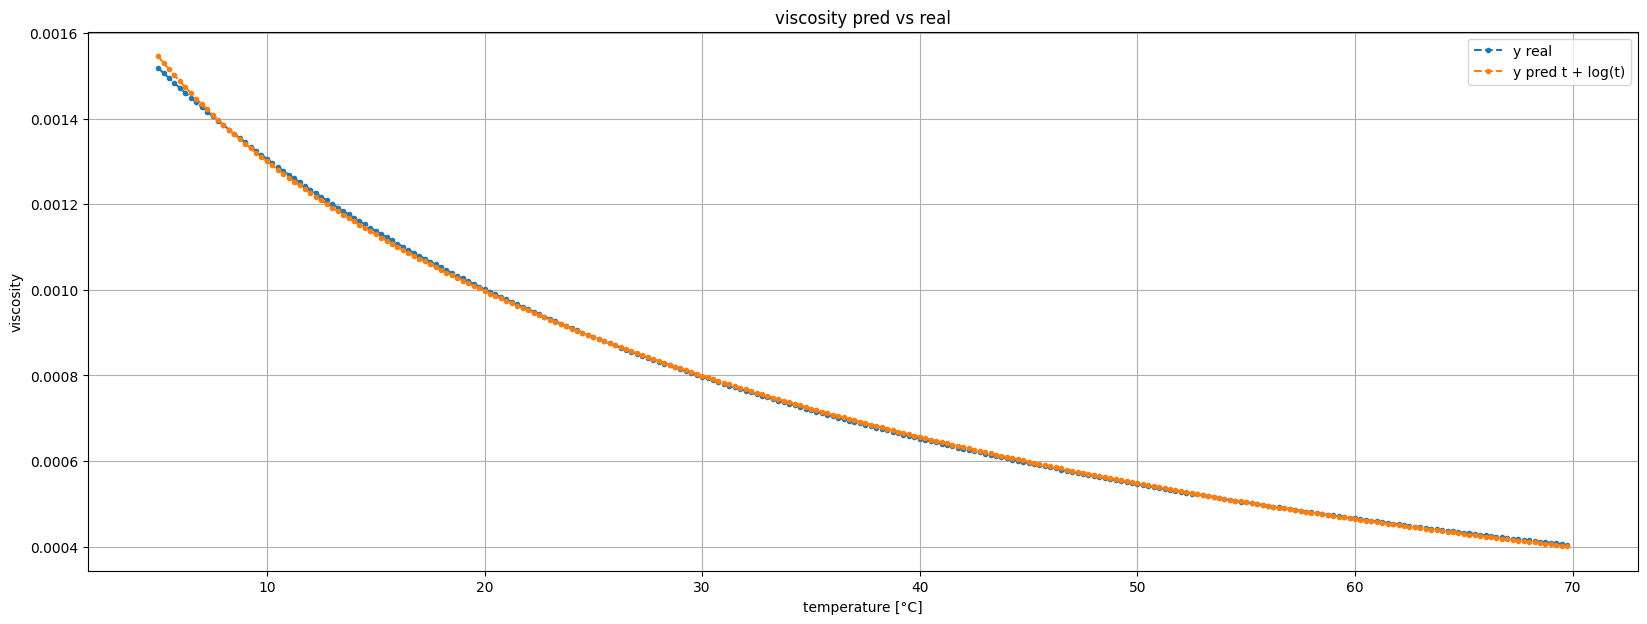

In [37]:
# ESTIMATING VISCOSITY
# since we assume constant permeate pressure, only temperature will be included in the model
# NB ok only for temperature >= 5 and <70, which is our interval of interest
# better model for 1 <= temperature <= 100 including also log temperature
# normally ultrafiltration [5,70] is enough, actually tipically <= 50
avg_prs_permeate = df_plot[df_plot['is_ON'] == True].groupby('is_ON')[['prs permeate [kPa]']].mean()['prs permeate [kPa]'].iloc[0]
avg_prs_permeate = 23.55 # the one given with file_idx = 5
print("average pressure permeate:", avg_prs_permeate)
df_visc = pd.DataFrame()
df_visc['temperature [°C]'] = list(np.arange(5, 70, 0.25))
#df_visc['log temperature [°C]'] = df_visc['temperature [°C]'].apply(lambda x : math.log(x))
df_visc['sqrt temperature [°C]'] = df_visc['temperature [°C]'].apply(lambda x : math.sqrt(x))
x = df_visc[['temperature [°C]', 'sqrt temperature [°C]']]
y = df_visc['temperature [°C]'].apply(lambda x : calc_viscosity(x, pressure_Pa=(101325+avg_prs_permeate), element='Water'))
df_visc['viscosity [Pa s]'] = y
model1, y_pred1, intercept1, coeffs1 = call_linear_model(x, y)
y_dict = {
    'y real'          : y,
    'y pred t + log(t)'  : y_pred1,
}

title = 'viscosity pred vs real'
y_ax_lbl='viscosity'
plot_time_series_1_axis(x=df_visc['temperature [°C]'], y_series=y_dict, x_ax_lbl='temperature [°C]', y_ax_lbl=y_ax_lbl, title=title, x_format=None)